# Setup

## Dependencies

In [2]:
import numpy as np
import PIL
import tensorflow as tf
import os
from matplotlib import pyplot as plt

from tensorflow import keras
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import Rescaling, RandomFlip, RandomRotation, RandomZoom, RandomTranslation
from keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D
from keras import regularizers

In [3]:
# Avoid OOM errors by setting GPU Memory Consumption Growth
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

## Functions

### Dataset & Preproces

In [ ]:
from pathlib import Path
import shutil
import imghdr

IMG_EXTS = ['jpeg','jpg', 'bmp', 'png']

def remove_invalid_images(data_dir):
  for image_class in os.listdir(data_dir):
      for image in os.listdir(os.path.join(data_dir, image_class)):
          image_path = os.path.join(data_dir, image_class, image)
          try:
              tip = imghdr.what(image_path)
              if tip not in IMG_EXTS:
                  print('Image not in ext list {}'.format(image_path))
                  os.remove(image_path)
          except Exception as e:
              print('Issue with image {}'.format(image_path))
              os.remove(image_path)


def load_dataset(data_dir, img_height=224, img_width=224, batch_size=32, seed=123):
  img_size = (img_height, img_width)

  train_ds = tf.keras.utils.image_dataset_from_directory (
    data_dir,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="training",
  )

  val_ds = tf.keras.utils.image_dataset_from_directory (
    data_dir,
    label_mode="categorical",
    batch_size=batch_size,
    image_size=img_size,
    shuffle=True,
    seed=seed,
    validation_split=0.2,
    subset="validation",
  )

  return train_ds, val_ds

In [4]:
def plot_dataset(ds, class_names):
  plt.figure(figsize=(10, 10))
  for images, labels in ds.take(1):
    for i in range(9):
      ax = plt.subplot(3, 3, i + 1)
      plt.imshow(images[i].numpy().astype("uint8"))
      plt.title(class_names[np.argmax(labels[i])])
      plt.axis("off")


def plot_dataset_distribution(dataset, class_names):
    num_images_per_class = [0] * len(class_names)

    for _, labels in dataset:
        # Convert one hot encoded
        labels = np.argmax(labels, axis=1)
        for label in labels:
            num_images_per_class[label] += 1

    # Create a bar plot showing the number of images per class
    plt.figure(figsize=(10, 8))
    bars = plt.bar(class_names, num_images_per_class, color='skyblue')

    plt.xlabel('Architects')
    plt.ylabel('Number of Images')
    plt.title(f'Number of Images per Class')
    plt.xticks(rotation=45)

    # Display numeric values on top of the bars
    for bar, num_images in zip(bars, num_images_per_class):
        plt.text(bar.get_x() + bar.get_width() / 2, num_images + 5, str(num_images),
                 ha='center', va='bottom', fontsize=8)

    plt.tight_layout()
    plt.show()

### Training

In [ ]:
from keras.metrics import Precision, Recall, BinaryAccuracy
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

def evaluate_model(model, val_ds):
  precision_metric = Precision()
  recall_metric = Recall()
  accuracy_metric = BinaryAccuracy()

  for batch in val_ds.as_numpy_iterator():
      X, y = batch
      yhat = model.predict(X)
      precision_metric.update_state(y, yhat)
      recall_metric.update_state(y, yhat)
      accuracy_metric.update_state(y, yhat)

  precision_result = precision_metric.result().numpy()
  recall_result = recall_metric.result().numpy()
  accuracy_result = accuracy_metric.result().numpy()

  print(f'Precision: {precision_result:.4f}, Recall: {recall_result:.4f}, Accuracy: {accuracy_result:.4f}')


def plot_confusion_matrix(model, val_ds, class_names):
  # Get true labels from validation dataset
  true_labels = []
  images = []
  for x, y in val_ds:
      images.extend(x.numpy())
      true_labels.extend(y.numpy())

  images = np.array(images)
  true_labels = np.argmax(true_labels, axis=1)

  # Make predictions using the validation dataset
  predicted_probs = model.predict(images)
  predicted_labels = np.argmax(predicted_probs, axis=1)

  # Generating the confusion matrix
  cm = confusion_matrix(true_labels, predicted_labels)

  # Displaying the confusion matrix using seaborn heatmap
  plt.figure(figsize=(8, 6))
  sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
  plt.xlabel('Predicted')
  plt.ylabel('Actual')
  plt.title('Confusion Matrix')
  plt.show()


def plot_performance(history):
  # Accessing training/validation accuracies and losses
  train_acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  train_loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs_range = range(1, len(train_acc) + 1)

  # Plotting accuracy
  plt.figure(figsize=(12, 4))
  plt.subplot(1, 2, 1)
  plt.plot(epochs_range, train_acc, label='Training Accuracy')
  plt.plot(epochs_range, val_acc, label='Validation Accuracy')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Training and Validation Accuracy')
  plt.legend()

  # Plotting loss
  plt.subplot(1, 2, 2)
  plt.plot(epochs_range, train_loss, label='Training Loss')
  plt.plot(epochs_range, val_loss, label='Validation Loss')
  plt.xlabel('Epochs')
  plt.ylabel('Loss')
  plt.title('Training and Validation Loss')
  plt.legend()

  plt.tight_layout()
  plt.show()

### t-SNE

In [ ]:
from sklearn.manifold import TSNE

def convert_numpy(ds):
  labels = []
  images = []

  # Unpack each element (x, y) from the dataset and convert to NumPy arrays
  for x, y in ds:
    images.extend(x.numpy())
    labels.extend(y.numpy())

  # Convert the list of images to a NumPy array
  images = np.array(images)
  # Convert one-hot encoded labels to integer indices using argmax
  labels = np.argmax(labels, axis=1)

  return images, labels

def extract_features(model, data):
  feature_extractor = Sequential(model.layers[:-1])
  return feature_extractor.predict(data)

def plot_dataset_tsne(features, labels, class_names):
  num_classes = len(class_names)
  plt.figure(figsize=(8, 6))
  for i in range(num_classes):
      plt.scatter(features[labels == i, 0], features[labels == i, 1], label=class_names[i])
  plt.title('2D Visualization of Dataset')
  plt.xlabel('t-SNE Dimension 1')
  plt.ylabel('t-SNE Dimension 2')
  plt.legend()
  plt.show()

def visualize_dataset_tsne(model, class_names, train_ds, val_ds):
  images_train, labels_train = convert_numpy(train_ds)
  images_val, labels_val = convert_numpy(val_ds)

  images = np.concatenate((images_train, images_val))
  labels = np.concatenate((labels_train, labels_val))

  visualize_dataset_tsne_numpy(model, class_names, images, labels)

def visualize_dataset_tsne_numpy(model, class_names, images, labels):
  print("Extracting features...")
  features = extract_features(model, images)

  print("t-SNE dimention reduction...")
  tsne = TSNE(n_components=2, random_state=42)
  reduced_features = tsne.fit_transform(features)

  plot_dataset_tsne(reduced_features, labels, class_names)

## Hyperparameters

In [134]:
IMG_HEIGHT, IMG_WIDTH = 224, 224 # 224x224 img size is common for ResNet and EfficientNet architectures
BATCH_SIZE = 32
SEED = 123 # Seed for loading and suffling the dataset (image_dataset_from_directory)

# Loading Dataset

## Architects-Top Dataset from Hugging Face

In [108]:
!git lfs install
!git clone https://huggingface.co/datasets/ebylmz/architects-top

Git LFS initialized.
fatal: destination path 'architects-top' already exists and is not an empty directory.


In [ ]:
data_dir = "/content/architects-top/all"
remove_invalid_images(data_dir)

In [111]:
train_ds, val_ds = load_dataset(data_dir, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED)

# Keep the number of classes for for the softmax activation
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

Found 1076 files belonging to 3 classes.
Using 861 files for training.
Found 1076 files belonging to 3 classes.
Using 215 files for validation.


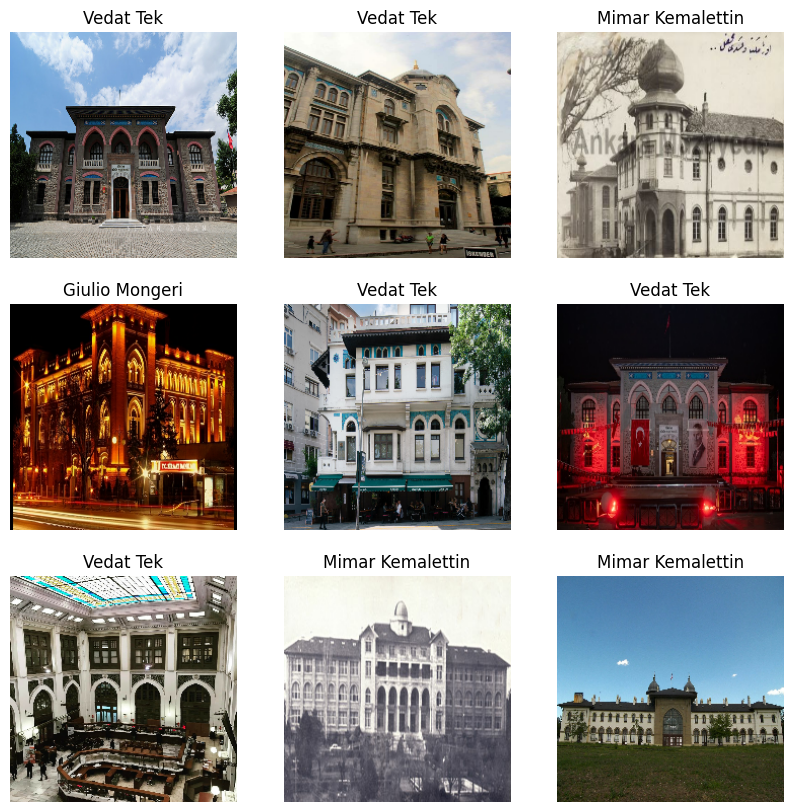

In [113]:
plot_dataset(train_ds, class_names)

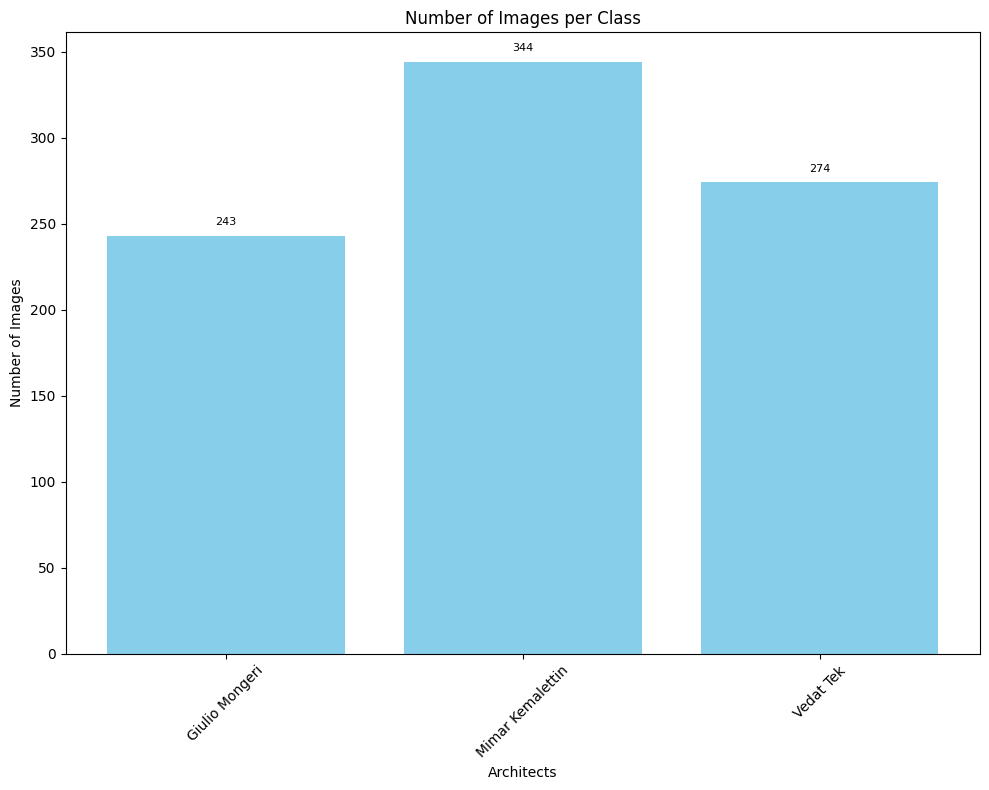

In [114]:
plot_dataset_distribution(train_ds, class_names)

## Architects Dataset from Hugging Face

In [55]:
!git lfs install
!git clone https://huggingface.co/datasets/ebylmz/architects

Git LFS initialized.
fatal: destination path 'architects' already exists and is not an empty directory.


In [64]:
data_dir = "/content/architects/data"

remove_invalid_images(data_dir)

In [66]:
train_ds, val_ds = load_dataset(data_dir, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED)

# Keep the number of classes for for the softmax activation
num_classes = len(train_ds.class_names)
class_names = train_ds.class_names

Found 1910 files belonging to 16 classes.
Using 1528 files for training.
Found 1910 files belonging to 16 classes.
Using 382 files for validation.


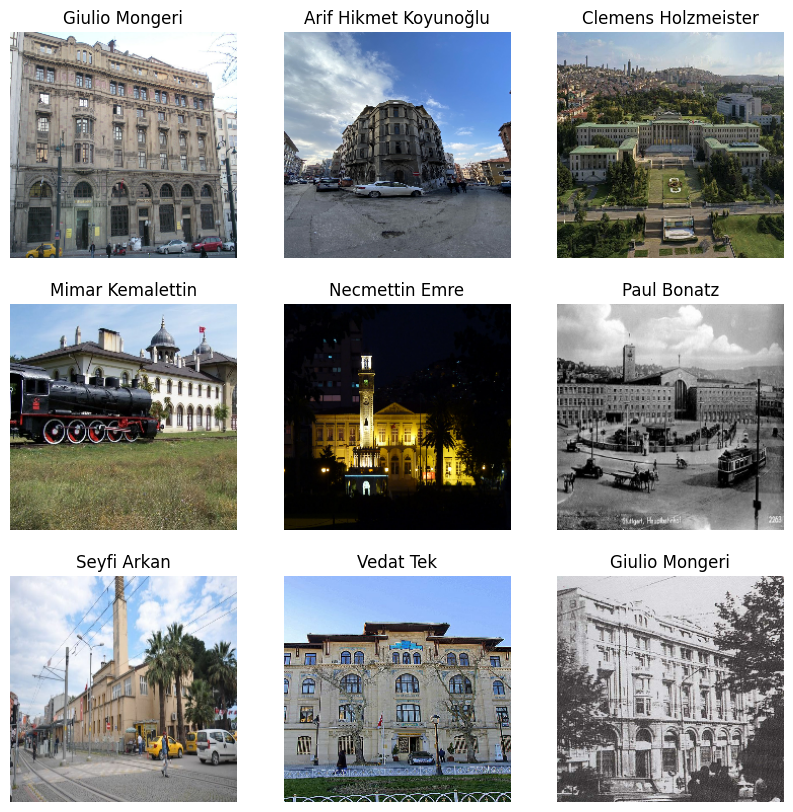

In [68]:
plot_dataset(train_ds, class_names)

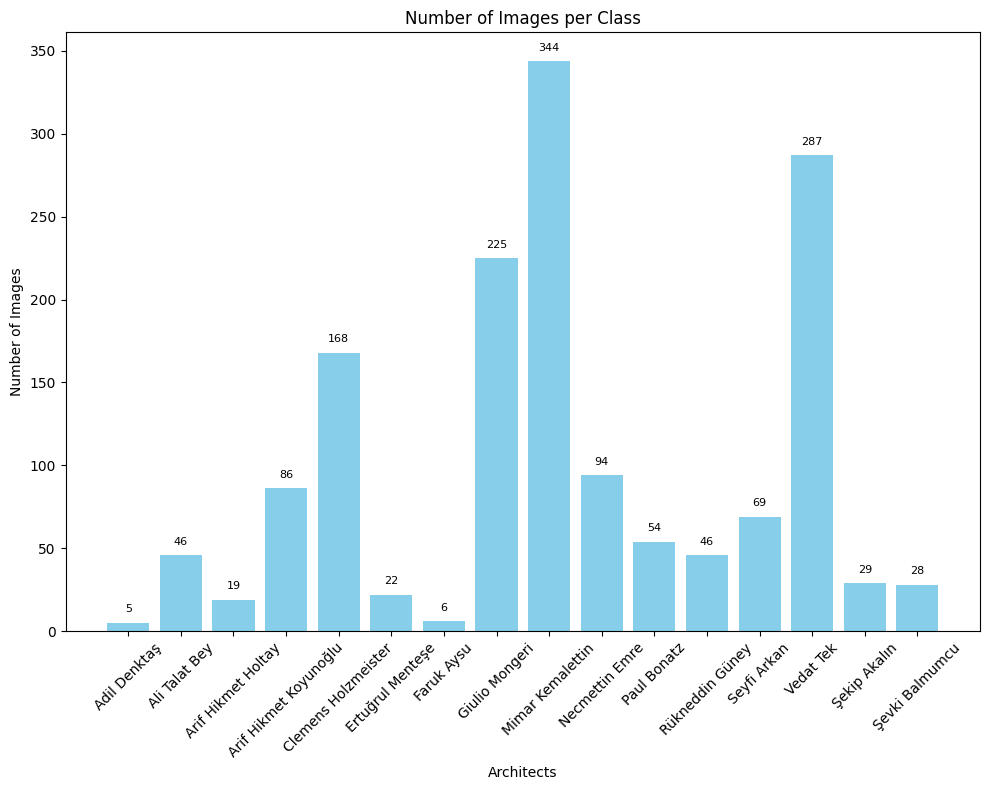

In [69]:
plot_dataset_distribution(train_ds, class_names)

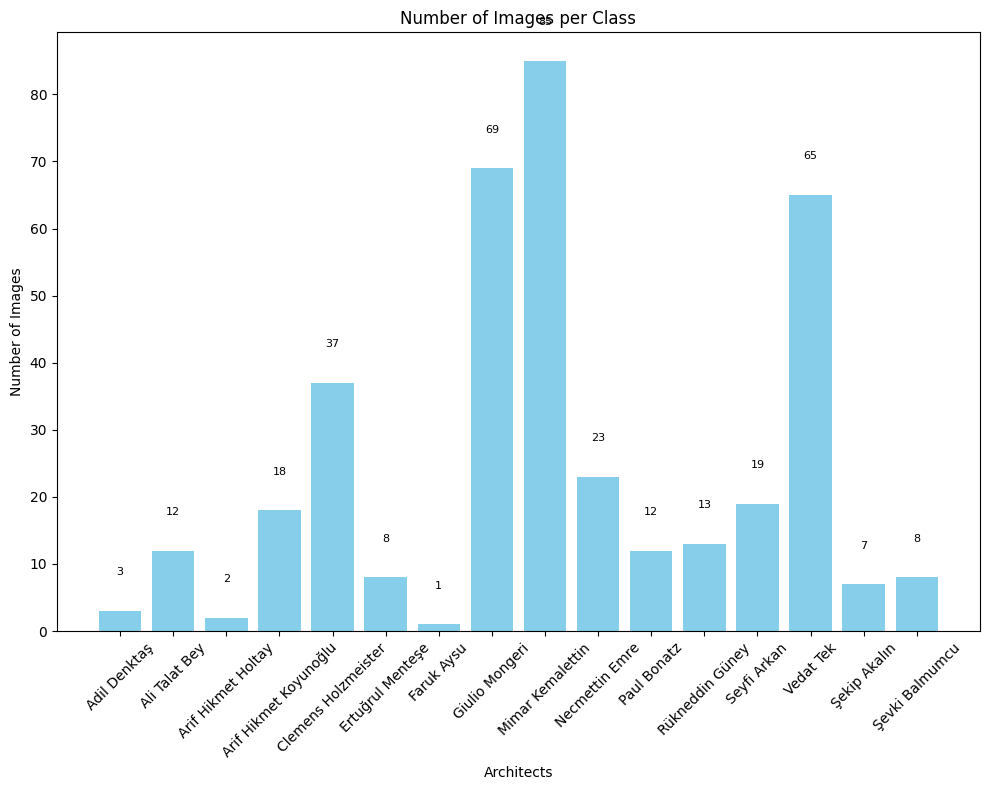

In [70]:
plot_dataset_distribution(val_ds, class_names)

## Architectural Styles Dataset from Kaggle

In [ ]:
from google.colab import files

# Upload your kaggle credentials
files.upload()

# !rm -r ~/.kaggle
!mkdir ~/.kaggle
!mv ./kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d dumitrux/architectural-styles-dataset
!unzip -q architectural-styles-dataset

# We will use the combination of google scraped and original dataset made by Zhe Xu
!rm -rf g-images-dataset/

Saving kaggle.json to kaggle.json
 99% 1.55G/1.56G [00:17<00:00, 157MB/s]
100% 1.56G/1.56G [00:17<00:00, 95.9MB/s]


In [ ]:
data_dir = "/content/architectural-styles-dataset"

remove_invalid_images(data_dir)

In [ ]:
styles_train_ds, styles_val_ds = load_dataset(data_dir, IMG_HEIGHT, IMG_WIDTH, BATCH_SIZE, SEED)

# Keep the number of classes for for the softmax activation
styles_num_classes = len(styles_train_ds.class_names)
styles_class_names = styles_train_ds.class_names

Found 10113 files belonging to 25 classes.
Using 8091 files for training.
Found 10113 files belonging to 25 classes.
Using 2022 files for validation.


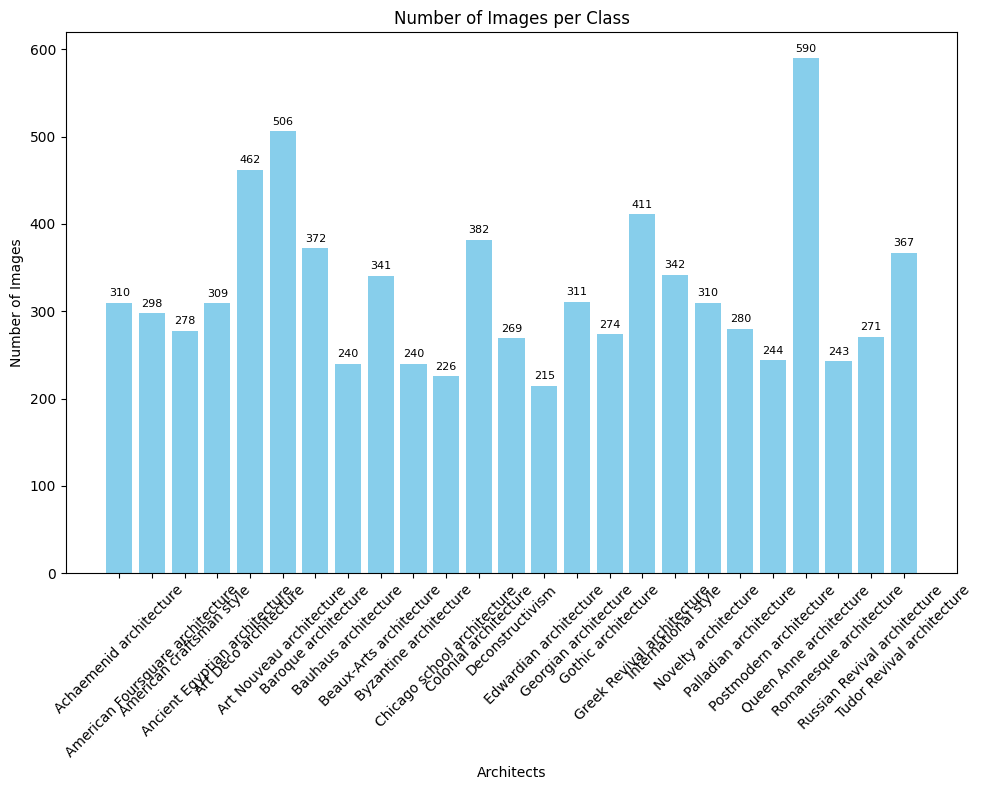

In [ ]:
plot_dataset_distribution(styles_train_ds, styles_class_names)

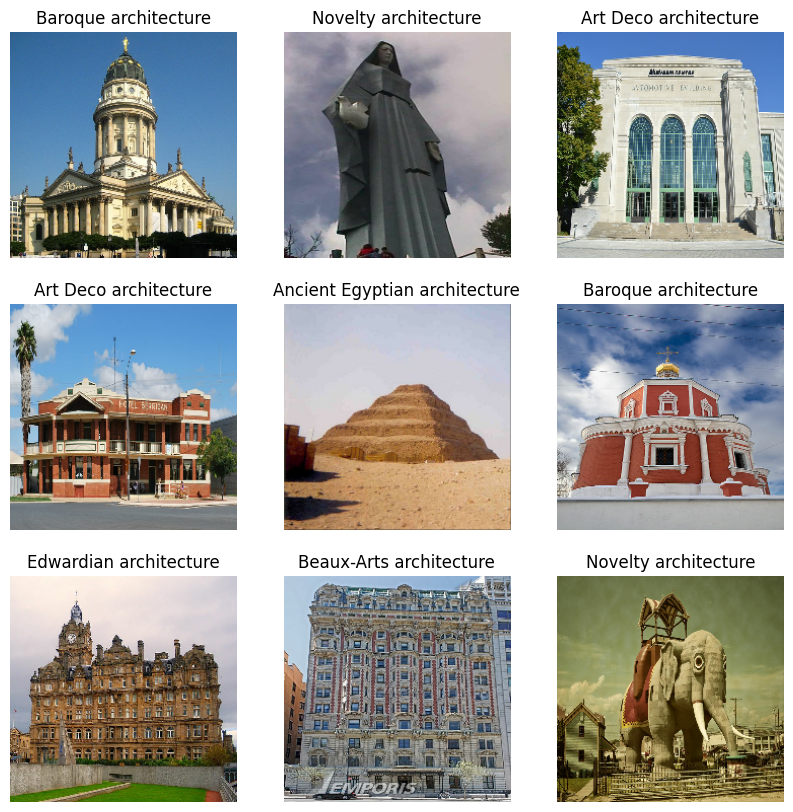

In [ ]:
plot_dataset(styles_train_ds, styles_class_names)

# Preprocessing Layers (Normalization & Augmentation)

In [130]:
# Standardizes pixel values to the [-1, 1] range
# Having features on a similar scale can help the gradient descent converge more quickly towards the minima
rescale = tf.keras.Sequential([
  Rescaling(scale=1/127.5, offset=-1)
])

data_augmentation = tf.keras.Sequential([
  RandomFlip("horizontal"),
  RandomRotation(0.1, fill_mode='nearest'),
  RandomZoom(0.1, fill_mode='nearest'),
])

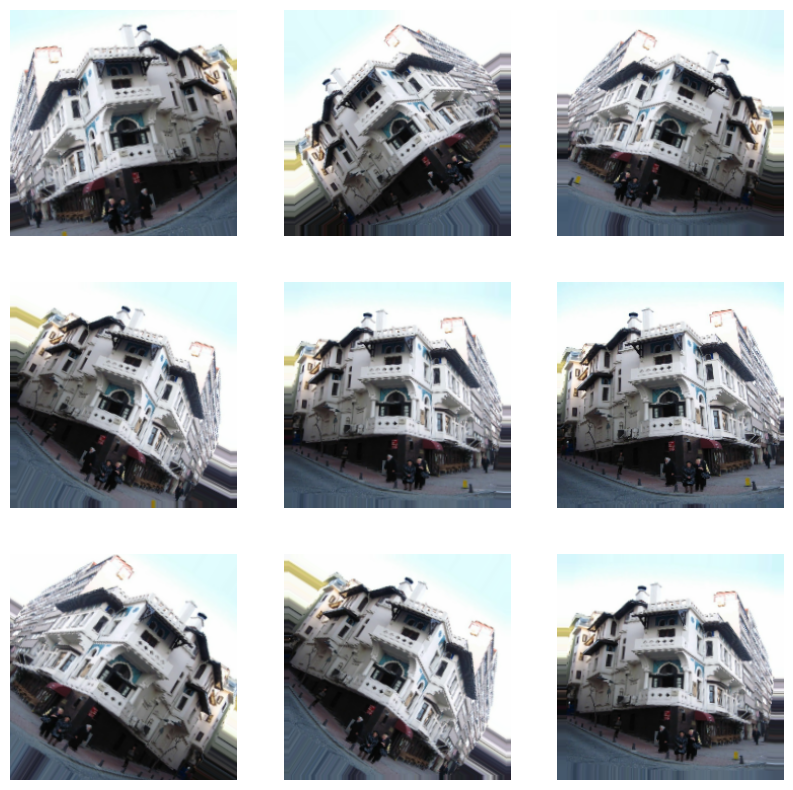

In [131]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
  for i in range(9):
    augmented_images = data_augmentation(images)
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(augmented_images[0].numpy().astype("uint8"))
    plt.axis("off")

# Convolutional Neural Network

In [133]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

EPOCHS = 50

model_file_path = "saved_models/arch_classifier_checkpoint_{epoch:02d}_{val_loss:.2f}.keras"

checkpoint = ModelCheckpoint(
    model_file_path,
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_freq='epoch')

early_stop = EarlyStopping(
    monitor='val_loss',
    min_delta=0, # Minimum change in the monitored quantity
    patience=5,
    mode='min')

lr_reducer = ReduceLROnPlateau(
    monitor="val_loss",
    factor=0.1,
    patience=3,
    min_lr=1e-6)

callbacks_list = [checkpoint, early_stop, lr_reducer]

## Training a Model from Scratch

In [ ]:
model = Sequential()
# Add the preprocessing layers you created earlier.
model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 21s 420ms/step - loss: 3.3794 - accuracy: 0.3403 - val_loss: 1.0730 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 14s 435ms/step - loss: 1.0845 - accuracy: 0.3926 - val_loss: 1.0872 - val_accuracy: 0.4093 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 15s 418ms/step - loss: 1.0774 - accuracy: 0.3995 - val_loss: 1.0584 - val_accuracy: 0.4372 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 536ms/step - loss: 1.0529 - accuracy: 0.4297 - val_loss: 1.0500 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 16s 492ms/step - loss: 1.0601 - accuracy: 0.4472 - val_loss: 1.0519 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 14s 421ms/step - loss: 1.0572 - accuracy: 0.4413 - val_loss: 1.0258 - val_accuracy: 0.4465 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 17s 5

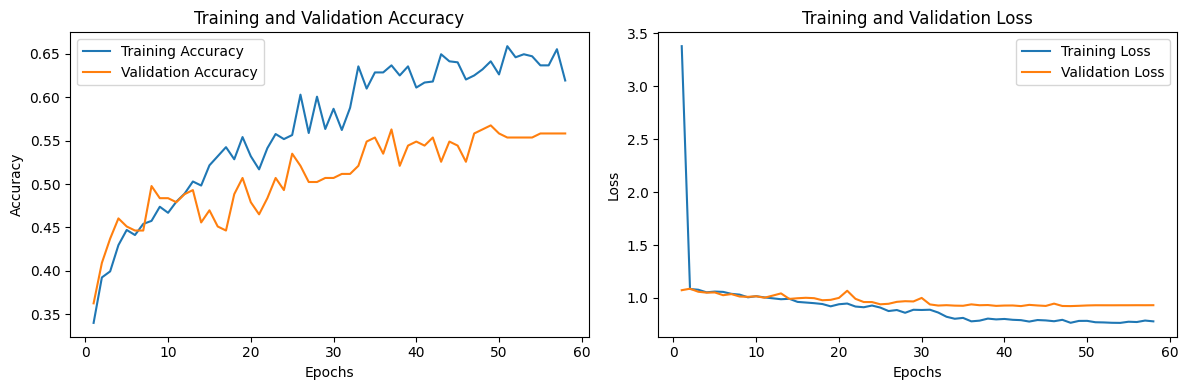

In [ ]:
plot_performance(history)

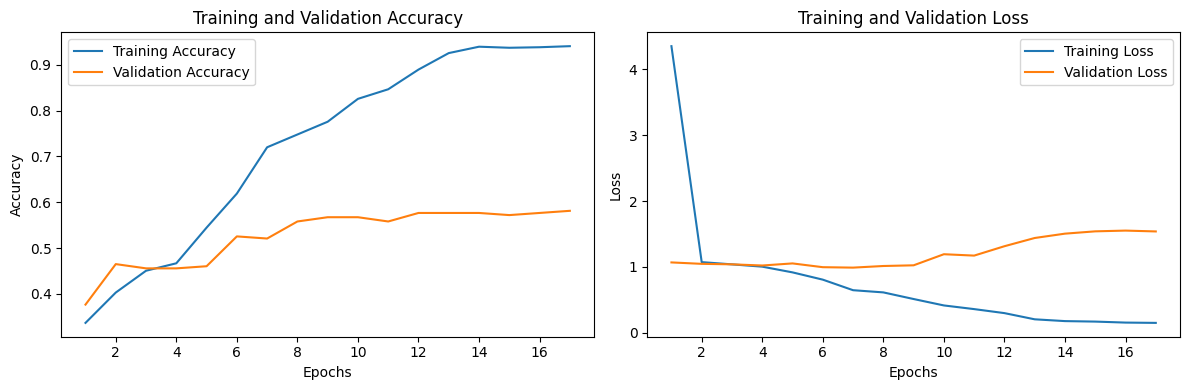

In [ ]:
plot_performance(history) # without any data augmentation (overfitting in 20 epoch)

In [ ]:
model = Sequential()
model.add(data_augmentation)

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3)))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())  # this converts our 3D feature maps to 1D feature vectors
model.add(Dense(64, activation='relu', kernel_initializer='he_uniform'))
model.add(Dropout(0.4))
model.add(Dense(num_classes, activation='softmax'))

model.compile(optimizer=keras.optimizers.Adam(), loss='categorical_crossentropy', metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 27s 570ms/step - loss: 5.1808 - accuracy: 0.3508 - val_loss: 1.0696 - val_accuracy: 0.4140 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 17s 522ms/step - loss: 1.0880 - accuracy: 0.3763 - val_loss: 1.0877 - val_accuracy: 0.3628 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 16s 437ms/step - loss: 1.0766 - accuracy: 0.3693 - val_loss: 1.0370 - val_accuracy: 0.4605 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 16s 488ms/step - loss: 1.0758 - accuracy: 0.3879 - val_loss: 1.0481 - val_accuracy: 0.3814 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 14s 435ms/step - loss: 1.0701 - accuracy: 0.4390 - val_loss: 1.0353 - val_accuracy: 0.4512 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 18s 556ms/step - loss: 1.0533 - accuracy: 0.4437 - val_loss: 1.0127 - val_accuracy: 0.4930 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 16s 4

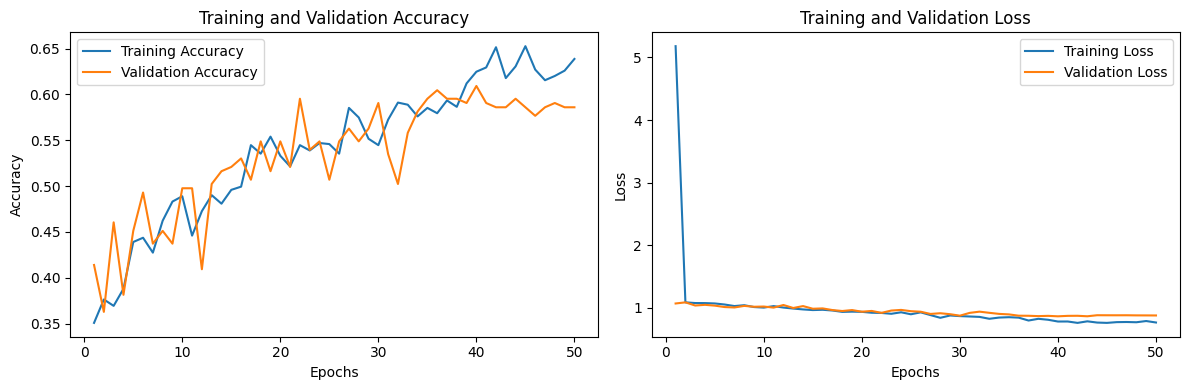

In [ ]:
plot_performance(history)

## Transfer Learning

 Transfer learning is a very good approach if we have less data for our problem statement.

In [12]:
from keras.applications import VGG16
from keras.applications import ResNet50V2
from keras.applications import EfficientNetB0

### VGG16

In [ ]:
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = keras.Input(shape=(224, 224, 3))

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = base_model(inputs, training=False)

x = keras.layers.GlobalAveragePooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
outputs = keras.layers.Dense(num_classes, activation='softmax')(x)

model = keras.Model(inputs, outputs)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 42s 1s/step - loss: 6.1498 - accuracy: 0.3171 - val_loss: 3.6271 - val_accuracy: 0.3442 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 22s 671ms/step - loss: 4.1077 - accuracy: 0.3914 - val_loss: 2.9257 - val_accuracy: 0.4279 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 23s 762ms/step - loss: 3.2265 - accuracy: 0.4472 - val_loss: 2.3381 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 509ms/step - loss: 2.7496 - accuracy: 0.4913 - val_loss: 2.0696 - val_accuracy: 0.5209 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 22s 691ms/step - loss: 2.3602 - accuracy: 0.5134 - val_loss: 1.7893 - val_accuracy: 0.5628 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 21s 563ms/step - loss: 1.8979 - accuracy: 0.5877 - val_loss: 1.6703 - val_accuracy: 0.5674 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 17s 516m

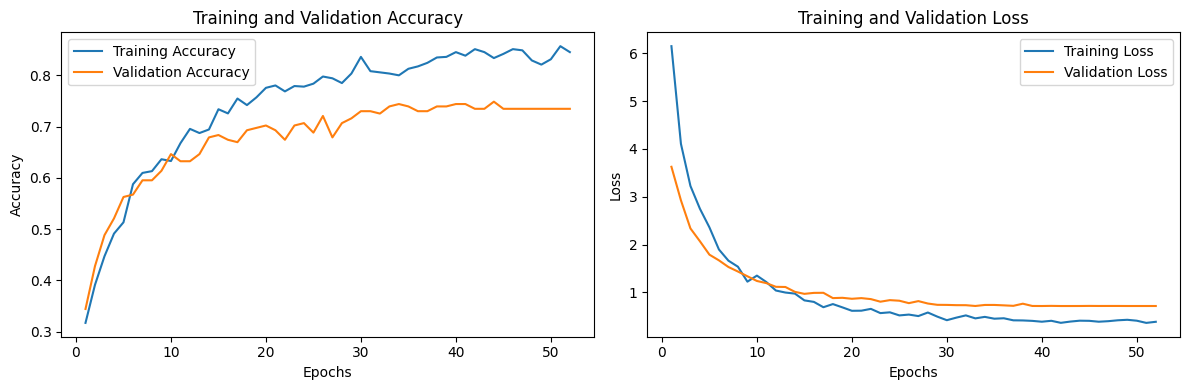

In [ ]:
plot_performance(history)

In [ ]:
model_dir = os.path.join('models','arch_classifier_vgg.keras')

model.save(model_dir)

In [ ]:
base_model = VGG16(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

# Freeze the base_model
base_model.trainable = False

inputs = tf.keras.Input(shape=(224, 224, 3))

x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = base_model(x, training=False)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - 20s 505ms/step - loss: 18.0154 - accuracy: 0.4135 - val_loss: 10.8436 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 18s 568ms/step - loss: 9.6995 - accuracy: 0.5447 - val_loss: 7.5787 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 23s 742ms/step - loss: 7.8952 - accuracy: 0.6028 - val_loss: 7.2021 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 27s 844ms/step - loss: 7.0434 - accuracy: 0.6481 - val_loss: 6.4548 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 17s 526ms/step - loss: 6.5520 - accuracy: 0.6574 - val_loss: 5.9435 - val_accuracy: 0.6837 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 23s 742ms/step - loss: 6.1063 - accuracy: 0.6539 - val_loss: 5.7369 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 21s

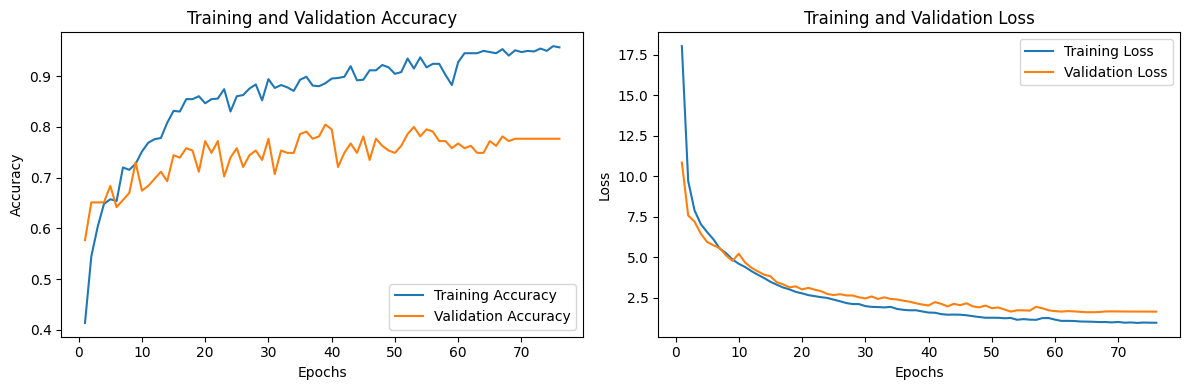

In [ ]:
plot_performance(history)

In [ ]:
IMG_SIZE = 224

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = VGG16(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.vgg16.preprocess_input(x)
x = base_model(x, training=False)

x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs, name="VGG16")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

58889256/58889256 [==============================] - 0s 0us/step
Epoch 1/50
27/27 [==============================] - 40s 982ms/step - loss: 1.4447 - accuracy: 0.4123 - val_loss: 1.2716 - val_accuracy: 0.4884 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 16s 478ms/step - loss: 1.0622 - accuracy: 0.5331 - val_loss: 0.9927 - val_accuracy: 0.5814 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 16s 490ms/step - loss: 0.9136 - accuracy: 0.6028 - val_loss: 0.8259 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 17s 519ms/step - loss: 0.8404 - accuracy: 0.6353 - val_loss: 0.8079 - val_accuracy: 0.6279 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 18s 483ms/step - loss: 0.7490 - accuracy: 0.6725 - val_loss: 0.7672 - val_accuracy: 0.6698 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 15s 468ms/step - loss: 0.7777 - accuracy: 0.6725 - val_loss: 0.7475 - val_accuracy: 0.6558 - lr: 0.0010

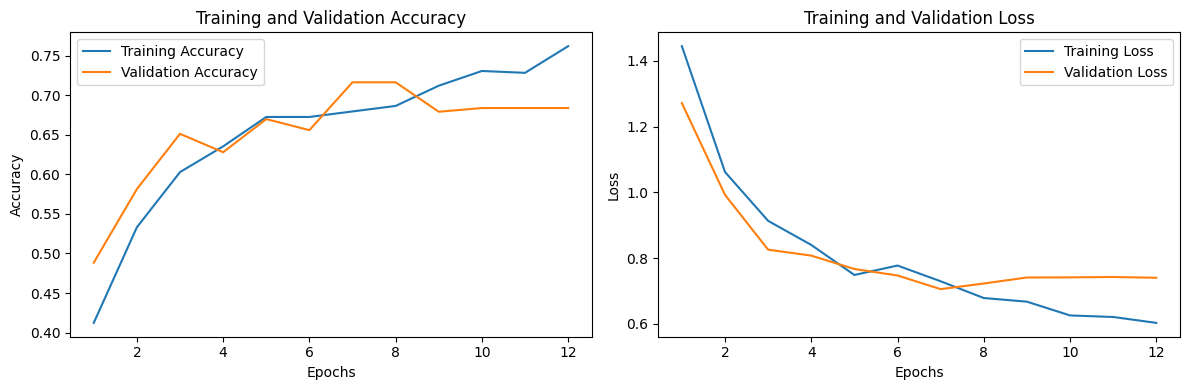

In [ ]:
plot_performance(history)

### ResNet

In [ ]:
IMG_SIZE = 224

base_model = ResNet50V2(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False)

# Freeze the pretrained weights
base_model.trainable = False

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
x = data_augmentation(inputs)
x = tf.keras.applications.resnet.preprocess_input(x)
x = base_model(x, training=False)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/100
27/27 [==============================] - ETA: 0s - loss: 16.9445 - accuracy: 0.4239

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


27/27 [==============================] - 22s 563ms/step - loss: 16.9445 - accuracy: 0.4239 - val_loss: 12.6506 - val_accuracy: 0.5907 - lr: 0.0010
Epoch 2/100
27/27 [==============================] - 17s 519ms/step - loss: 11.1812 - accuracy: 0.5854 - val_loss: 9.0714 - val_accuracy: 0.6512 - lr: 0.0010
Epoch 3/100
27/27 [==============================] - 17s 529ms/step - loss: 8.7429 - accuracy: 0.6283 - val_loss: 7.7646 - val_accuracy: 0.6419 - lr: 0.0010
Epoch 4/100
27/27 [==============================] - 17s 534ms/step - loss: 7.2154 - accuracy: 0.6748 - val_loss: 6.3695 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 5/100
27/27 [==============================] - 21s 699ms/step - loss: 6.1088 - accuracy: 0.7096 - val_loss: 5.5509 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 6/100
27/27 [==============================] - 17s 537ms/step - loss: 5.3901 - accuracy: 0.7131 - val_loss: 4.8767 - val_accuracy: 0.7302 - lr: 0.0010
Epoch 7/100
27/27 [==============================] - 18s 528ms/step

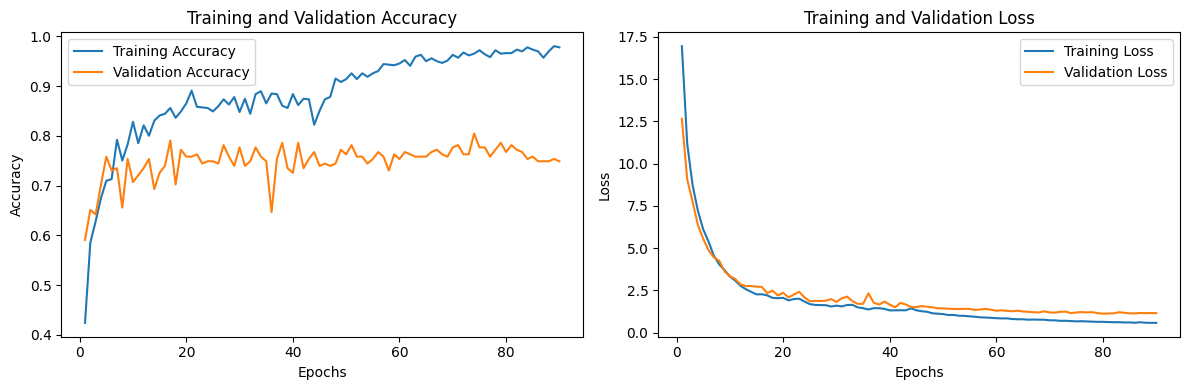

In [ ]:
plot_performance(history)

In [ ]:
IMG_SIZE = 224

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = ResNet50V2(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.resnet_v2.preprocess_input(x)
x = base_model(x, training=False)

x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs, name="ResNet")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/50
27/27 [==============================] - 22s 485ms/step - loss: 1.2987 - accuracy: 0.4774 - val_loss: 0.9174 - val_accuracy: 0.5721 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 15s 469ms/step - loss: 0.7629 - accuracy: 0.6876 - val_loss: 0.8400 - val_accuracy: 0.6047 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 15s 469ms/step - loss: 0.6658 - accuracy: 0.7317 - val_loss: 0.7731 - val_accuracy: 0.6744 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 15s 437ms/step - loss: 0.5847 - accuracy: 0.7654 - val_loss: 0.7115 - val_accuracy: 0.6930 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 16s 454ms/step - loss: 0.5305 - accuracy: 0.7921 - val_loss: 0.7287 - val_accuracy: 0.6605 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 15s 451ms/step - loss: 0.4845 - accuracy: 0.7991 - val_loss: 0.7289 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 16s 492ms/st

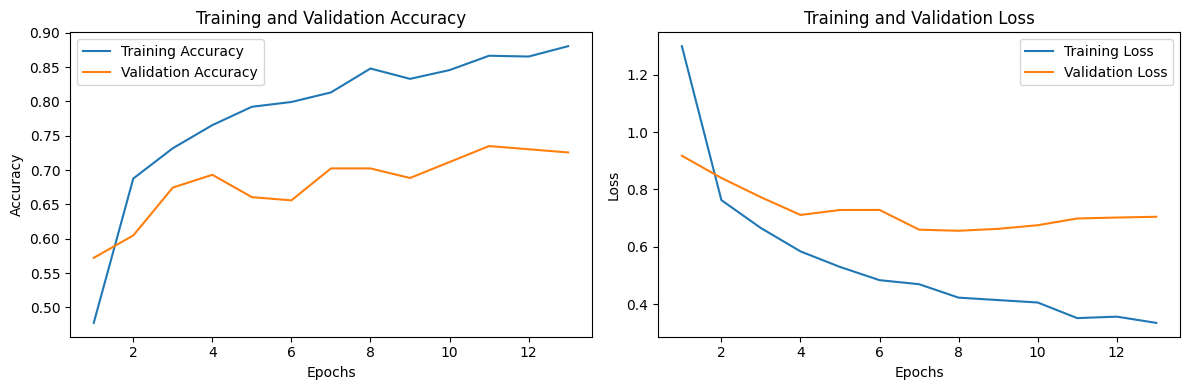

In [ ]:
plot_performance(history)

### EfficientNet

In [132]:
IMG_SIZE = 224

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)

x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dropout(0.2, name="top_dropout")(x)
outputs = Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs, name="EfficientNet")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

16705208/16705208 [==============================] - 0s 0us/step


NameError: name 'EPOCHS' is not defined

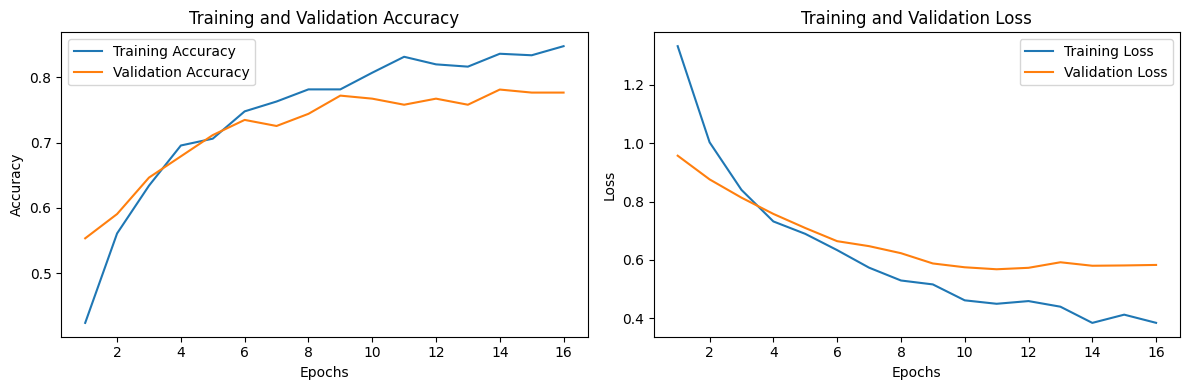

In [ ]:
plot_performance(history) # arch_classifier_efficientnet_pooling.keras

In [ ]:
IMG_SIZE = 224

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)

x = Flatten()(x)
x = Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu', kernel_regularizer=regularizers.l2(0.01))(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation='softmax')(x)

model = Model(inputs=inputs, outputs=outputs)

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/50
27/27 [==============================] - 28s 654ms/step - loss: 10.5454 - accuracy: 0.4890 - val_loss: 8.4842 - val_accuracy: 0.7116 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 16s 494ms/step - loss: 7.8002 - accuracy: 0.6539 - val_loss: 6.5529 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 16s 476ms/step - loss: 5.9249 - accuracy: 0.7398 - val_loss: 5.4285 - val_accuracy: 0.7209 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 15s 459ms/step - loss: 4.6742 - accuracy: 0.8014 - val_loss: 4.3572 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 15s 451ms/step - loss: 3.8781 - accuracy: 0.8084 - val_loss: 3.7294 - val_accuracy: 0.7860 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 15s 463ms/step - loss: 3.3812 - accuracy: 0.8374 - val_loss: 3.3786 - val_accuracy: 0.7767 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 15s 464ms/s

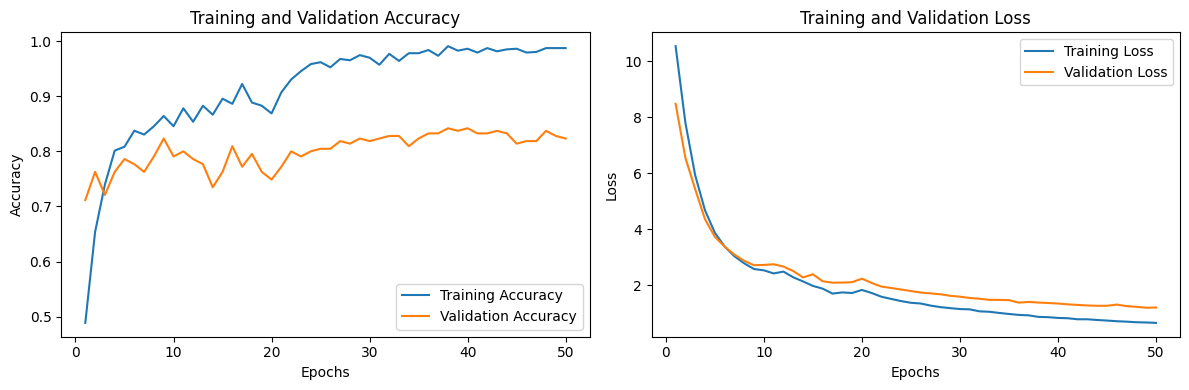

In [ ]:
plot_performance(history) # arch_classifier_efficientnet_dense.keras

In [ ]:
IMG_SIZE = 224

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)

x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs, name="EfficientNet")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/50
27/27 [==============================] - 27s 510ms/step - loss: 1.2835 - accuracy: 0.4599 - val_loss: 0.9128 - val_accuracy: 0.5535 - lr: 0.0010
Epoch 2/50
27/27 [==============================] - 23s 704ms/step - loss: 0.7520 - accuracy: 0.6945 - val_loss: 0.7996 - val_accuracy: 0.6558 - lr: 0.0010
Epoch 3/50
27/27 [==============================] - 15s 455ms/step - loss: 0.6218 - accuracy: 0.7503 - val_loss: 0.7147 - val_accuracy: 0.7023 - lr: 0.0010
Epoch 4/50
27/27 [==============================] - 17s 516ms/step - loss: 0.5537 - accuracy: 0.7770 - val_loss: 0.6636 - val_accuracy: 0.7581 - lr: 0.0010
Epoch 5/50
27/27 [==============================] - 16s 478ms/step - loss: 0.5350 - accuracy: 0.7898 - val_loss: 0.6141 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 6/50
27/27 [==============================] - 16s 490ms/step - loss: 0.4195 - accuracy: 0.8293 - val_loss: 0.5856 - val_accuracy: 0.7628 - lr: 0.0010
Epoch 7/50
27/27 [==============================] - 17s 487ms/st

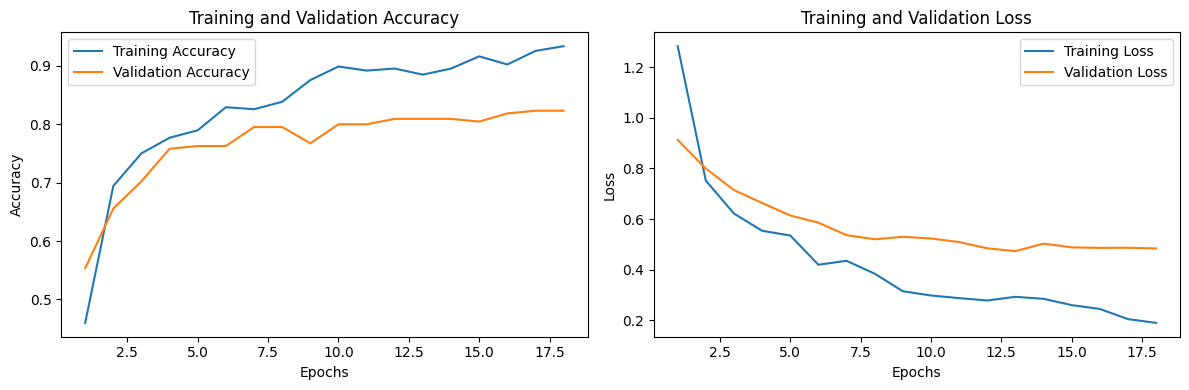

In [ ]:
plot_performance(history)

7/7 [==============================] - 2s 68ms/step


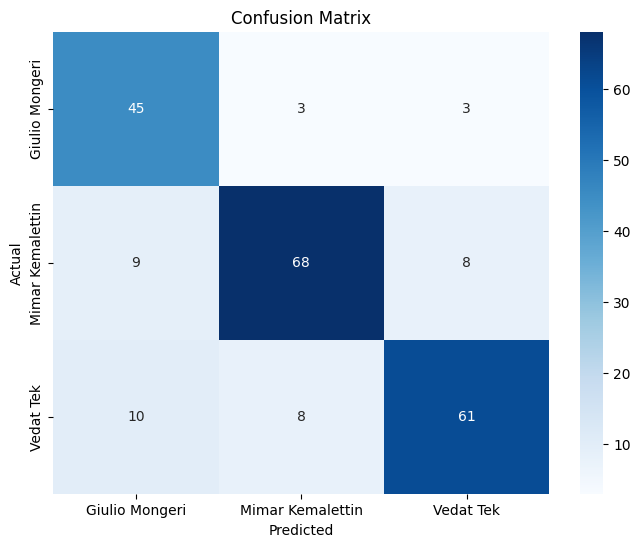

In [126]:
plot_confusion_matrix(model, val_ds, class_names)

In [128]:
loss, acc = model.evaluate(val_ds)
print("Model accuracy: {:5.2f}%".format(100 * acc))

7/7 [==============================] - 3s 67ms/step - loss: 0.4733 - accuracy: 0.8093
Model accuracy: 80.93%


### EfficientNet on Architects Dataset

In [ ]:
IMG_SIZE = 224

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)

x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs, name="EfficientNet")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=val_ds,
    callbacks=callbacks_list)

Epoch 1/50
48/48 [==============================] - 50s 564ms/step - loss: 2.7176 - accuracy: 0.2310 - val_loss: 2.1879 - val_accuracy: 0.4110 - lr: 0.0010
Epoch 2/50
48/48 [==============================] - 27s 494ms/step - loss: 1.8370 - accuracy: 0.4719 - val_loss: 1.8806 - val_accuracy: 0.4974 - lr: 0.0010
Epoch 3/50
48/48 [==============================] - 43s 687ms/step - loss: 1.4602 - accuracy: 0.5582 - val_loss: 1.6258 - val_accuracy: 0.5654 - lr: 0.0010
Epoch 4/50
48/48 [==============================] - 34s 560ms/step - loss: 1.2910 - accuracy: 0.6178 - val_loss: 1.4403 - val_accuracy: 0.5890 - lr: 0.0010
Epoch 5/50
48/48 [==============================] - 26s 480ms/step - loss: 1.1103 - accuracy: 0.6780 - val_loss: 1.2821 - val_accuracy: 0.6361 - lr: 0.0010
Epoch 6/50
48/48 [==============================] - 28s 510ms/step - loss: 0.9736 - accuracy: 0.7009 - val_loss: 1.2388 - val_accuracy: 0.6126 - lr: 0.0010
Epoch 7/50
48/48 [==============================] - 26s 484ms/st

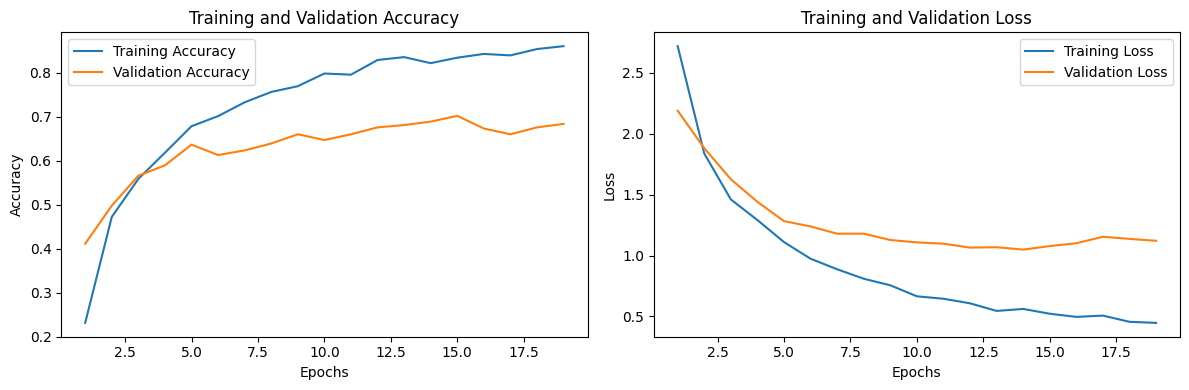

In [ ]:
plot_performance(history)

12/12 [==============================] - 1s 62ms/step


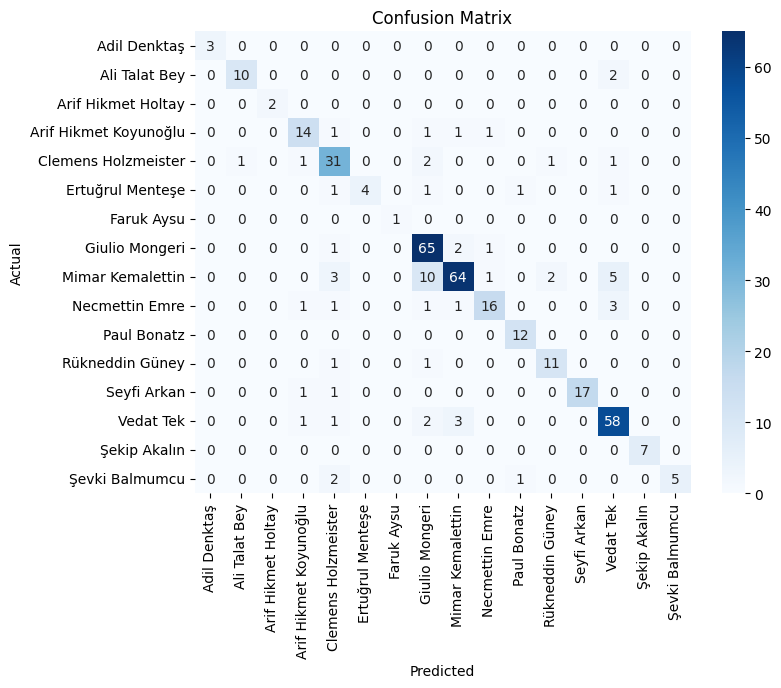

In [71]:
plot_confusion_matrix(model, val_ds, class_names)

### EfficientNet on Architectural Styles Dataset

In [ ]:
IMG_SIZE = 224

inputs = tf.keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
base_model = EfficientNetB0(include_top=False, input_tensor=inputs, weights="imagenet")

# Freeze the pretrained weights
base_model.trainable = False

# Rebuild top
x = data_augmentation(inputs)
x = tf.keras.applications.efficientnet.preprocess_input(x)
x = base_model(x, training=False)

x = GlobalAveragePooling2D(name="avg_pool")(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.2)(x)
outputs = Dense(styles_num_classes, activation="softmax", name="pred")(x)

model = keras.Model(inputs, outputs, name="EfficientNet")

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(), metrics=['accuracy'])

history = model.fit(
    styles_train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    validation_data=styles_val_ds,
    callbacks=callbacks_list)

Epoch 1/50
253/253 [==============================] - 61s 186ms/step - loss: 2.3472 - accuracy: 0.3169 - val_loss: 1.6184 - val_accuracy: 0.5138 - lr: 0.0010
Epoch 2/50
253/253 [==============================] - 38s 146ms/step - loss: 1.7024 - accuracy: 0.4747 - val_loss: 1.3935 - val_accuracy: 0.5702 - lr: 0.0010
Epoch 3/50
253/253 [==============================] - 38s 148ms/step - loss: 1.5297 - accuracy: 0.5259 - val_loss: 1.3270 - val_accuracy: 0.5925 - lr: 0.0010
Epoch 4/50
253/253 [==============================] - 41s 158ms/step - loss: 1.4115 - accuracy: 0.5531 - val_loss: 1.2762 - val_accuracy: 0.5959 - lr: 0.0010
Epoch 5/50
253/253 [==============================] - 39s 153ms/step - loss: 1.3192 - accuracy: 0.5845 - val_loss: 1.2347 - val_accuracy: 0.6113 - lr: 0.0010
Epoch 6/50
253/253 [==============================] - 40s 156ms/step - loss: 1.2649 - accuracy: 0.5967 - val_loss: 1.2164 - val_accuracy: 0.6162 - lr: 0.0010
Epoch 7/50
253/253 [==============================] 

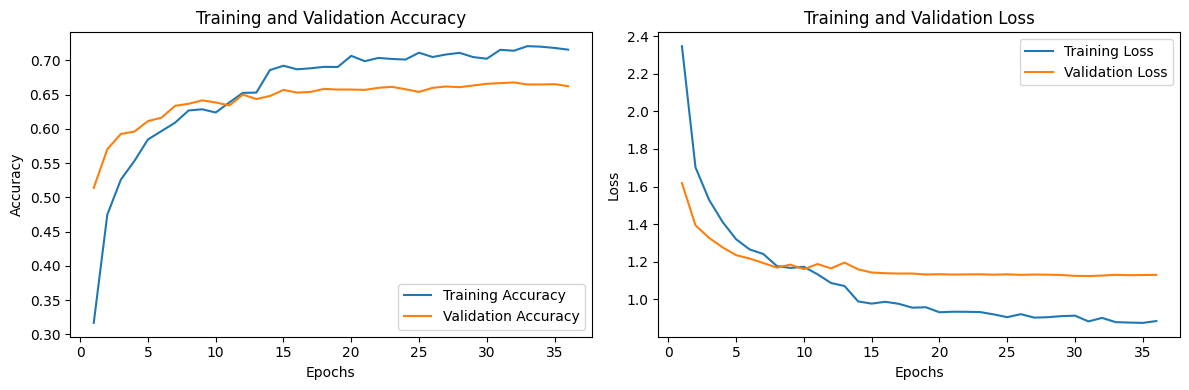

In [ ]:
plot_performance(history) # default architecture + addtional dense layer

64/64 [==============================] - 10s 103ms/step


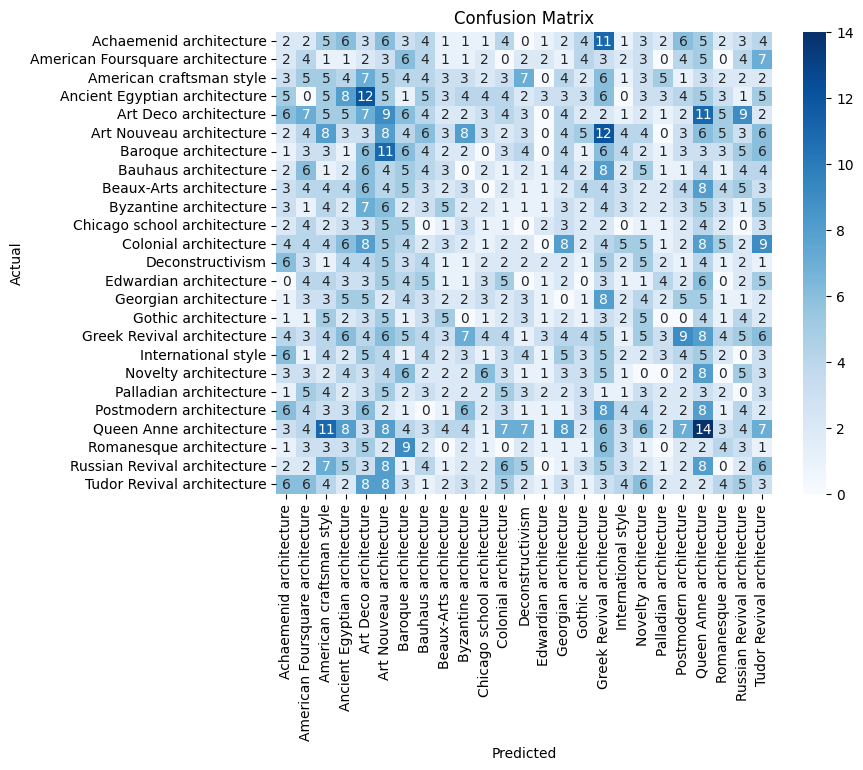

In [ ]:
plot_confusion_matrix(model, styles_val_ds, styles_class_names)

# Hyperparameter Tuning - Grid Search


In [ ]:
train_images = np.concatenate(list(train_ds.map(lambda x, y : x)))
val_images = np.concatenate(list(val_ds.map(lambda x, y : x)))

train_labels = np.concatenate(list(train_ds.map(lambda x, y : y)))
val_labels = np.concatenate(list(val_ds.map(lambda x, y : y)))

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.datasets import make_classification
from scikeras.wrappers import KerasClassifier

# Define a function that builds the model with the specified hyperparameters
def create_model(dropout):
  # TODO: Define the final model here
  model = Sequential()
  model.add(Flatten(input_shape=(224, 224, 3)))
  model.add(Dropout(dropout))
  model.add(Dense(128, activation='relu'))
  model.add(Dropout(dropout))
  model.add(Dense(num_classes, activation='softmax'))

  model.compile(loss='categorical_crossentropy',
                       optimizer=keras.optimizers.Adam(),
                       metrics=['accuracy'])
  return model

# Creating a KerasClassifier using the build function
model = KerasClassifier(model=create_model, dropout=0.2)

# Define the grid search parameters
param_grid = {
    'batch_size':[8, 16, 32, 64],
    # 'optimizers': ['rmsprop', 'adam']
    # 'learning_rate': [0.01, 0.1],
    # 'epochs':[50,70],
    # 'momentum': [0.9, 0.99],
    # 'weight_decay': [0.0001, 0.0005],
    'dropout': [0.2,0.3,0.4]
}

# Perform grid search
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring='accuracy', cv=5)
grid_result = grid.fit(train_images, train_labels)

In [ ]:
# Print the best parameters and score
print("Best Parameters: ", grid_result.best_params_)
print("Best Score: ", grid_result.best_score_)

# Evaluate the best model on the test data
best_model = grid_result.best_estimator_
test_accuracy = best_model.score(val_images, val_labels)
print("Test Accuracy: ", test_accuracy)

# K-Fold Cross Validation

K-fold cross-validation is applied when evaluating the performance of a machine learning model to ensure robustness and generalization. It is particularly useful in situations where the dataset is limited, and there is a need to make the most out of the available data. K-fold cross-validation involves dividing the dataset into k equally-sized folds, training the model on k-1 folds, and validating it on the remaining fold. This process is repeated k times, with each fold serving as a validation set exactly once. By averaging the performance metrics across all folds, K-fold cross-validation provides a more reliable estimate of the model's performance, reducing the impact of variations in the data splitting process. It helps to identify whether the model performs consistently across different subsets of the data, and it can be especially beneficial in cases where the initial random split might introduce bias or variance into the evaluation.

In [ ]:
from sklearn.model_selection import KFold

train_images = np.concatenate(list(train_ds.map(lambda x, y : x)))
val_images = np.concatenate(list(val_ds.map(lambda x, y : x)))

train_labels = np.concatenate(list(train_ds.map(lambda x, y : y)))
val_labels = np.concatenate(list(val_ds.map(lambda x, y : y)))

inputs = np.concatenate((train_images, val_images), axis=0)
targets = np.concatenate((train_labels, val_labels), axis=0)

In [ ]:
inputs.max(), inputs.min()

(1.0, -1.0)

In [ ]:
# Define a simple CNN model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Compile the model
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [ ]:
# Number of folds for cross-validation
num_folds = 5
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)

fold = 0
all_fold_accuracies = []

for train_index, test_index in kfold.split(inputs, targets):
  fold += 1
  print(f"Training on fold {fold}...")

  X_train_fold, X_val_fold = inputs[train_index], inputs[test_index]
  y_train_fold, y_val_fold = targets[train_index], targets[test_index]

  # Train the model
  model.fit(X_train_fold, y_train_fold, epochs=5, validation_data=(X_val_fold, y_val_fold))

  # Evaluate on the validation set of the current fold
  val_loss, val_accuracy = model.evaluate(X_val_fold, y_val_fold)
  print(f"Validation Accuracy on fold {fold}: {val_accuracy:.4f}")


# Calculate the average accuracy
average_accuracy = np.mean(all_fold_accuracies)
print(f"\nAverage Validation Accuracy across all folds: {average_accuracy:.4f}")

# Optionally, you can save the model or perform further analysis after all folds
# model.save("final_model.h5")

# K-means Clustering

## Loading Our Final Model from Hugging Face

In [52]:
!git clone https://huggingface.co/ebylmz/architects-models

Cloning into 'architects-models'...
remote: Enumerating objects: 19, done.
remote: Counting objects: 100% (15/15), done.
remote: Compressing objects: 100% (15/15), done.
remote: Total 19 (delta 3), reused 0 (delta 0), pack-reused 4
Unpacking objects: 100% (19/19), 3.03 KiB | 443.00 KiB/s, done.


In [115]:
from keras.models import load_model

# final_model = load_model(os.path.join('saved_models','model-checkpoint-80-1.13.hdf5'))
final_model = load_model(os.path.join('architects-models','arch_classifier_efficientnet_82.keras'))
# final_model = load_model(os.path.join('architects-models','arch_classifier_efficientnet_architects_all.keras'))

final_model.summary()

Model: "EfficientNet"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 224, 224, 3)       0         
                                                                 
 efficientnetb0 (Functional  (None, 7, 7, 1280)        4049571   
 )                                                               
                                                                 
 avg_pool (GlobalAveragePoo  (None, 1280)              0         
 ling2D)                                                         
                                                                 
 batch_normalization_1 (Bat  (None, 1280)              5120      
 chNormalization)                                                
                                                      

## architects-top dataset (all)   

Extracting features...
34/34 [==============================] - 5s 50ms/step
t-SNE dimention reduction...


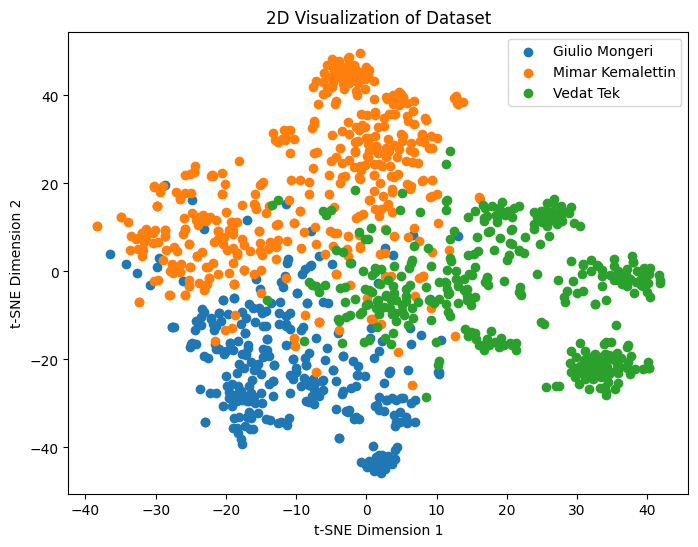

In [123]:
visualize_dataset_tsne(final_model, class_names, train_ds, val_ds) # arch_classifier_efficientnet.keras (0.80 accuracy)

## architects-top dataset (single)

### Loading architects-top (single) dataset

In [87]:
data_dir = "/content/architects-top/single"

remove_invalid_images(data_dir)

Image not in ext list /content/architects-top/single/Vedat Tek/moda-iskelesi.jpg


In [88]:
ds_single = tf.keras.utils.image_dataset_from_directory (
  data_dir,
  label_mode="categorical",
  batch_size=BATCH_SIZE,
  image_size=(IMG_HEIGHT, IMG_WIDTH),
  shuffle=True,
  seed=SEED,
)

Found 35 files belonging to 3 classes.


In [91]:
# Keep the number of classes for for the softmax activation
num_classes_single = len(ds_single.class_names)
class_names_single = ds_single.class_names

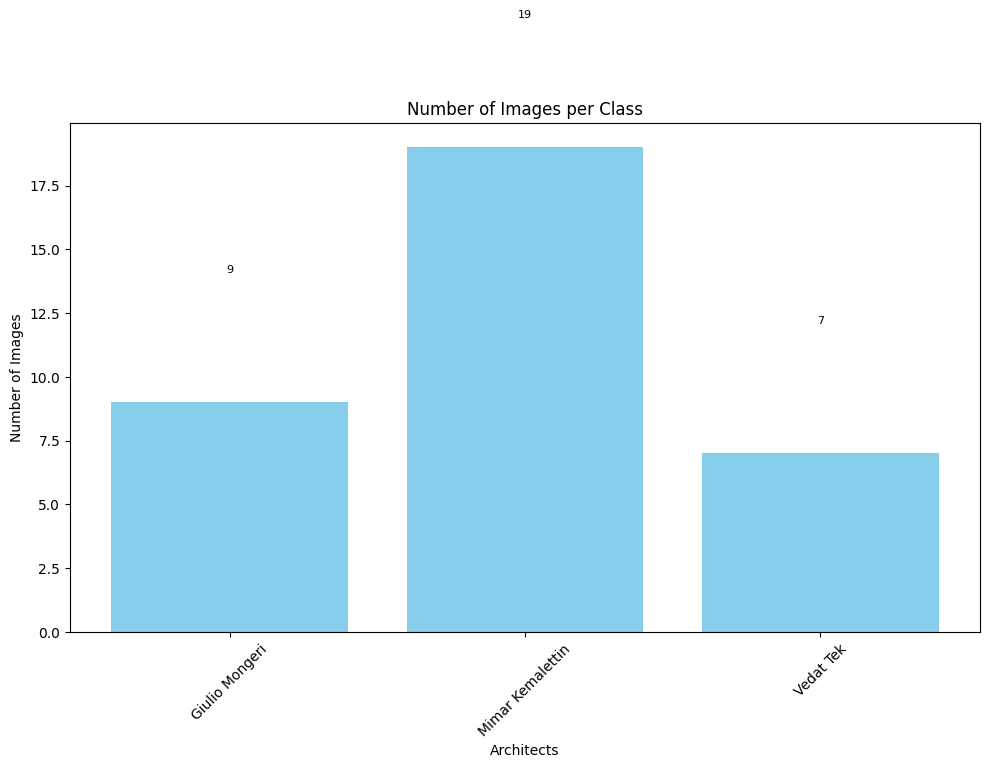

In [93]:
plot_dataset_distribution(ds_single, class_names_single)

### Clustering

Extracting features...
2/2 [==============================] - 3s 69ms/step
t-SNE dimention reduction...


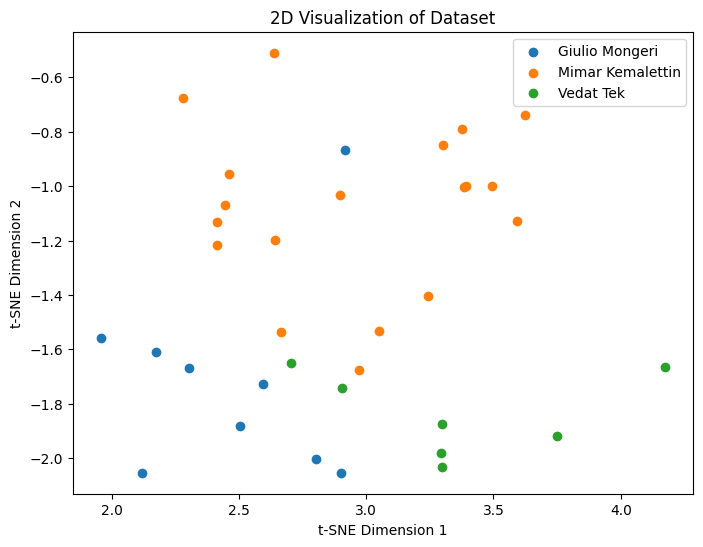

In [105]:
images, labels = convert_numpy(ds_single)

visualize_dataset_tsne_numpy(final_model, class_names_single, images, labels) # arch_classifier_efficientnet.keras (0.80 accuracy)

## architects dataset   

In [ ]:
visualize_dataset_tsne(final_model, class_names, train_ds, val_ds) # arch_classifier_efficientnet.keras (0.80 accuracy)

## architectural-styles dataset   

Extracting features...
64/64 [==============================] - 10s 108ms/step
t-SNE dimention reduction...


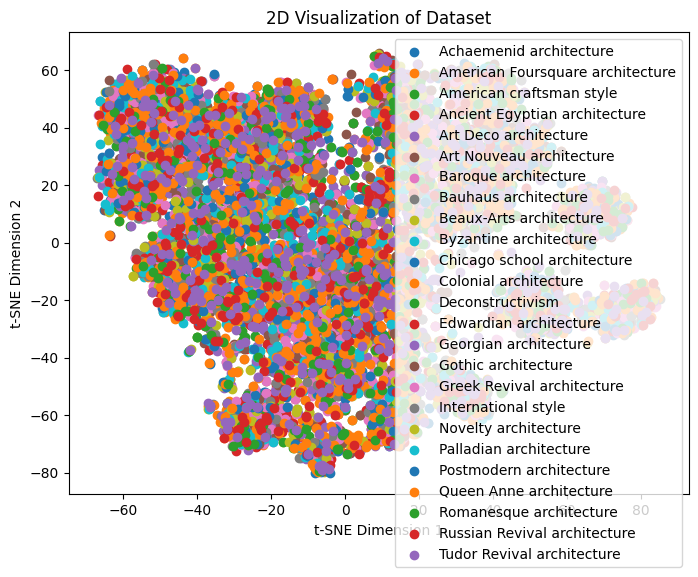

In [ ]:
visualize_dataset_tsne(final_model, styles_class_names, styles_train_ds, styles_val_ds) # arch_classifier_efficientnet_architectural_styles.keras